In [15]:
# Cell: Imports and helpers
import os

import numpy as np
import pandas as pd
import torch

from utils import train_one_epoch

NOTEBOOK_ROOT = os.path.dirname(os.path.abspath("tests.ipynb"))
EMB_PATH = os.path.join(NOTEBOOK_ROOT, "models", "cbir_embeddings.pt")
PATHS_CSV = os.path.join(NOTEBOOK_ROOT, "models", "cbir_image_paths.csv")

print("Notebook root:", NOTEBOOK_ROOT)
print("Embeddings path:", EMB_PATH)
print("Paths CSV:", PATHS_CSV)


def load_embeddings(path=EMB_PATH):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Embeddings file not found: {path}")
    emb = torch.load(path)
    if isinstance(emb, torch.Tensor):
        emb = emb.cpu().numpy()
    emb = np.asarray(emb)
    return emb


def load_paths(path=PATHS_CSV, skip_header=True):
    """Load image paths from CSV. By default skip the first row (header/metadata)."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Paths CSV not found: {path}")
    # some CSVs include a header or metadata in the first row; skip it by default
    if skip_header:
        df = pd.read_csv(path, header=None, skiprows=1)
    else:
        df = pd.read_csv(path, header=None)
    return df.iloc[:, 0].astype(str).tolist()


Notebook root: /home/tiberiu/Documents/TAID/SCAV/Similar-Images-Recognition
Embeddings path: /home/tiberiu/Documents/TAID/SCAV/Similar-Images-Recognition/models/cbir_embeddings.pt
Paths CSV: /home/tiberiu/Documents/TAID/SCAV/Similar-Images-Recognition/models/cbir_image_paths.csv


In [16]:
# Cell: retrieval helper


def retrieve(embeddings, idx, k=5, metric="euclidean"):
    """Return the indices of the top-k most similar items to embeddings[idx].
    metric: 'euclidean' or 'cosine'
    """
    if not (0 <= idx < embeddings.shape[0]):
        raise IndexError("query index out of range")
    q = embeddings[idx]
    if metric == "cosine":
        # cosine similarity: higher is better
        qnorm = q / (np.linalg.norm(q) + 1e-12)
        norms = np.linalg.norm(embeddings, axis=1) + 1e-12
        emb_norm = embeddings / norms[:, None]
        sims = emb_norm.dot(qnorm)
        order = np.argsort(-sims)
    else:
        # euclidean (ascending)
        dists = np.linalg.norm(embeddings - q, axis=1)
        order = np.argsort(dists)
    return order[:k]


In [17]:
# Cell: Run CBIR tests (assertions)
emb = load_embeddings()
paths = load_paths()

print("Embeddings shape:", emb.shape)
print("Number of paths:", len(paths))

# Basic checks
assert emb.ndim == 2, f"Embeddings must be 2-D, got ndim={emb.ndim}"
assert emb.shape[0] == len(paths), (
    f"Number of embeddings ({emb.shape[0]}) != number of paths ({len(paths)})"
)

n = emb.shape[0]
indices_to_test = [0, n // 2, max(0, n - 1)] if n >= 3 else list(range(n))

for i in indices_to_test:
    ks = 5 if n >= 5 else n
    ids = retrieve(emb, i, k=ks, metric="euclidean")
    # self-match should be first
    assert ids[0] == i, f"Self-match failed for index {i}: top result {ids[0]}"
    # distances should be non-decreasing
    d = np.linalg.norm(emb[ids] - emb[i], axis=1)
    assert np.all(d[:-1] <= d[1:] + 1e-9), f"Distances not sorted for query {i}"

# Path format checks (first few)
for p in paths[:10]:
    assert isinstance(p, str) and len(p) > 0, f"Invalid path: {p}"

print("All CBIR assertions passed for basic checks.")


Embeddings shape: (4738, 128)
Number of paths: 4738
All CBIR assertions passed for basic checks.


Running short training: samples=400, epochs=5, device=cuda
Epoch 1/5 | train_loss=0.0723 val_loss=0.0231 train_acc=0.5656 val_acc=0.5625 time=7.22s
Epoch 1/5 | train_loss=0.0723 val_loss=0.0231 train_acc=0.5656 val_acc=0.5625 time=7.22s
Epoch 2/5 | train_loss=0.0562 val_loss=0.0286 train_acc=0.7344 val_acc=0.7375 time=7.22s
Epoch 2/5 | train_loss=0.0562 val_loss=0.0286 train_acc=0.7344 val_acc=0.7375 time=7.22s
Epoch 3/5 | train_loss=0.0585 val_loss=0.0235 train_acc=0.7531 val_acc=0.7500 time=7.22s
Epoch 3/5 | train_loss=0.0585 val_loss=0.0235 train_acc=0.7531 val_acc=0.7500 time=7.22s
Epoch 4/5 | train_loss=0.0363 val_loss=0.0322 train_acc=0.8281 val_acc=0.7750 time=7.21s
Epoch 4/5 | train_loss=0.0363 val_loss=0.0322 train_acc=0.8281 val_acc=0.7750 time=7.21s
Epoch 5/5 | train_loss=0.0412 val_loss=0.0346 train_acc=0.8344 val_acc=0.6750 time=7.28s
Epoch 5/5 | train_loss=0.0412 val_loss=0.0346 train_acc=0.8344 val_acc=0.6750 time=7.28s


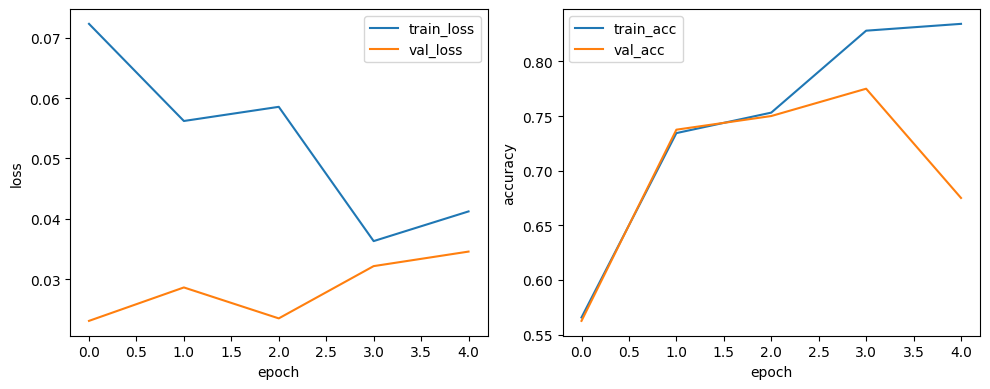


Training run complete. Summary:
train_loss: [0.07228238768875599, 0.056202830746769905, 0.05854744128882885, 0.036320175603032114, 0.04123407900333405]
val_loss: [0.023116258283456165, 0.02864875302960475, 0.023526978213340044, 0.03217934320370356, 0.03458532846222321]
train_acc: [0.5656249999999982, 0.7343749999999977, 0.7531249999999976, 0.8281249999999973, 0.8343749999999973]
val_acc: [0.562499999999993, 0.7374999999999908, 0.7499999999999907, 0.7749999999999904, 0.6749999999999916]
train_f1: [0.6713947990539243, 0.792176039119322, 0.793733681461658, 0.8493150684926574, 0.86304909560674]
val_f1: [0.6956521739125775, 0.7835051546386824, 0.7619047619042719, 0.7857142857137899, 0.7111111111106369]


In [18]:
# Metrics, short training run, and plots
import time

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from classes import SiameseDataset, SiameseNet
from classes.ContrastiveLoss import ContrastiveLoss
from main import Config, get_transforms

# Helpers


def compute_metrics(model, loader, criterion, device, threshold=1.0):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for img1, img2, target in loader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            target = target.to(device)

            z1, z2 = model(img1, img2)
            loss = criterion(z1, z2, target)
            running_loss += loss.item()

            dists = torch.norm(z1 - z2, dim=1)
            preds = (dists < threshold).long().cpu()
            all_preds.append(preds)
            all_targets.append(target.view(-1).long().cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    TP = int(((all_preds == 1) & (all_targets == 1)).sum())
    TN = int(((all_preds == 0) & (all_targets == 0)).sum())
    FP = int(((all_preds == 1) & (all_targets == 0)).sum())
    FN = int(((all_preds == 0) & (all_targets == 1)).sum())

    eps = 1e-12
    accuracy = (TP + TN) / (TP + TN + FP + FN + eps)
    precision = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)

    avg_loss = running_loss / len(loader)

    return avg_loss, {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": TP,
        "fp": FP,
        "fn": FN,
        "tn": TN,
    }


# Prepare small dataset from existing paths
train_tf, val_tf = get_transforms()
cfg = Config()

df_all = pd.DataFrame({"path": load_paths()})
if len(df_all) < 20:
    raise RuntimeError("Not enough images to run a short training demo (need >=20)")

n_samples = min(400, len(df_all))  # cap for quick runs
subset = df_all.sample(n=n_samples, random_state=cfg.SEED).reset_index(drop=True)
train_df, val_df = train_test_split(subset, test_size=0.2, random_state=cfg.SEED)

train_dataset = SiameseDataset(train_df, transform=train_tf)
val_dataset = SiameseDataset(val_df, transform=val_tf)

train_loader = DataLoader(
    train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=0
)

# Model and training setup
model = SiameseNet(embedding_dim=cfg.EMBEDDING_DIM).to(cfg.DEVICE)
criterion = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.LR)

EPOCHS = min(5, 10)

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_f1": [],
    "val_f1": [],
}

print(
    f"Running short training: samples={n_samples}, epochs={EPOCHS}, device={cfg.DEVICE}"
)

for epoch in range(EPOCHS):
    t0 = time.perf_counter()
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, cfg.DEVICE)
    t1 = time.perf_counter()

    # Evaluate metrics on train and val
    train_loss_eval, train_metrics = compute_metrics(
        model, train_loader, criterion, cfg.DEVICE, threshold=1.0
    )
    val_loss_eval, val_metrics = compute_metrics(
        model, val_loader, criterion, cfg.DEVICE, threshold=1.0
    )

    history["train_loss"].append(train_loss_eval)
    history["val_loss"].append(val_loss_eval)
    history["train_acc"].append(train_metrics["accuracy"])
    history["val_acc"].append(val_metrics["accuracy"])
    history["train_f1"].append(train_metrics["f1"])
    history["val_f1"].append(val_metrics["f1"])

    print(
        f"Epoch {epoch + 1}/{EPOCHS} | train_loss={train_loss_eval:.4f} val_loss={val_loss_eval:.4f} "
        f"train_acc={train_metrics['accuracy']:.4f} val_acc={val_metrics['accuracy']:.4f} "
        f"time={(t1 - t0):.2f}s"
    )

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.tight_layout()
plt.show()

print("\nTraining run complete. Summary:")
for k in ["train_loss", "val_loss", "train_acc", "val_acc", "train_f1", "val_f1"]:
    print(f"{k}: {history[k]}")
